### Compared to '1D_MultigridNeuralOperator', only adjust the function 'dense_block' to enlarge the architecture of the neural network of level 64 of the initial V cycle, and only run that neural network.

In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.6.2
2.6.0


In [2]:
from keras.layers import Input, Dense, TimeDistributed, Layer
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Build training permeability dataset (permeability curves)

In [3]:
# preparing 20k perm curves each having 64 points

perm_no = 20000
perm_curves_64 = np.zeros((perm_no, 64))

# (1) set all points of a perm curve as a constant sampled from 20 to 200
perm_lows = np.random.randint(20, 200, size=perm_no)
perm_curves_64 = (perm_curves_64 + 1) * np.expand_dims(perm_lows, axis = -1)

#(2) randomly select sand intervals and set high perm values for them.
for i in range(perm_no):
    # ramdomly choose sand (with high perm values) numbers for each perm curve, from 1 to 3 
    channel_no = np.random.randint(1, 3)
    # for the leftmost sand; expect the leftmost sand interval to be as left as possible, otherwise the preedicted pressure curve 
    # would decrease very quickly. Here, the left is the north in the paper.
    left_1 = np.random.randint(0, 5)
    width_1 = np.random.randint(5, 25)
    value_1 = np.random.randint(1700, 3000)
    perm_curves_64[i, left_1: left_1 + width_1] = value_1    
    
    for j in range(1, channel_no):
        left = np.random.randint(4, 60)
        width = np.random.randint(5, 25)
        value = np.random.randint(1700, 3000)
        perm_curves_64[i, left: min(left + width, 63)] = value

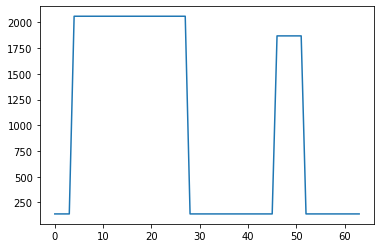

In [4]:
plt.plot(range(64), perm_curves_64[1153])

### 2. Load 100 perm curves and 100 pressure curves calculated from Eclipse, for test

In [3]:
perm64_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_perm_64.txt'
test_perm_64pixel = np.loadtxt(perm64_fname, dtype='float', delimiter= ' ')
print(test_perm_64pixel.shape)

(100, 64)


In [4]:
pres64_fname ='/scratch/users/suihong/MultiGrid_1D/' + 'test_pres_64.txt'
test_press_1day_64pixel = np.loadtxt(pres64_fname, dtype='float', delimiter= ' ')
print(test_press_1day_64pixel.shape)

(100, 64)


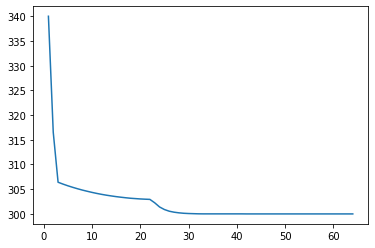

In [5]:
plt.plot(range(1, 65), test_press_1day_64pixel[0])

### 3. Train neural operator

#### (1) Define architectures, losses, and other helper functions

In [10]:
class RangeConversion(Layer):
    def __init__(self, range_in, range_out): # input and output range 
        [self.range_in_sm, self.range_in_lg] = range_in
        [self.range_out_sm, self.range_out_lg] = range_out            
        super(RangeConversion, self).__init__()
    def call(self, parameters):
        parameters_out = (parameters - self.range_in_sm) / (self.range_in_lg - self.range_in_sm) * (self.range_out_lg - self.range_out_sm) + self.range_out_sm
        return parameters_out
                    
def dense_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('%d_pixel' % block_pixel):
        layer1 = Dense(pixel*5, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(x)
        layer2 = Dense(pixel*5, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(layer1)        
        return layer2            

initializer = tf.keras.initializers.GlorotNormal()    
def create_dense_model(type = 'original', pixel = 64, initializer = tf.keras.initializers.GlorotNormal()):
    # type: 'original' for original model producing pressure curve from perm curve; 
    #       'error' for error model producing pressure errors from (perm curve + residual curve) 
    # pixel: pixel number of input and output curves, a value from (64, 32, 16, 8)

    if type == 'original':
        t = Input(shape = (1, pixel,), name = 'input')
        x = RangeConversion([0, 3000], [-1, 1])(t)
    elif type == 'error':
        t = Input(shape = (2, pixel,), name = 'input')
        x = tf.concat([RangeConversion([0, 3000], [-1, 1])(t[:, 0]), t[:, 1]], axis = 1, name = 'input_rangeconversion')
    
    lod = int(np.log2(pixel))  # from 4 to 1
    for i in range(lod, 1, -1):
        x = dense_block(x, i, pixel)
    output_pre = Dense(pixel, activation='linear', kernel_initializer=initializer, bias_initializer= initializer)(x) 
    
    if type == 'original':
        output = tf.reshape(output_pre, [-1, 64, 1])
    elif type == 'error':
        output = tf.expand_dims(output_pre, axis = -1)
 
    return Model(t, output)


In [11]:
# calculate residual matrix from PDE using finite difference method 
def residual_matrix(network_inputs, network_outputs):  # network_outputs of shape (N, 100, 1)      
    type = 'original' if network_inputs.shape[1] == 1 else 'error'
    pixel = network_inputs.shape[-1]
    
    dt = 1
    dx = 50.* (64 / pixel)
    miu = 2
    Ct = 1.8*10**(-2)
    unit_trans_para = 8.52702    
   
    if type == 'original':
        bound_sta_value = 340  # north boundary constant pressure value
        bound_end_value = 300  # sonth boundary constant pressure value
    elif type == 'error':
        bound_sta_value = 0
        bound_end_value = 0        
          
    bound_sta = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1))+bound_sta_value
    bound_end = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1))+bound_end_value  
    init_map = tf.zeros(shape = (tf.shape(network_outputs)[0], pixel, 1))+bound_end_value
    
    network_outputs = tf.concat([bound_sta, network_outputs[:, 1:-1], bound_end], axis = 1)  # shape of (N, 100, 1) 
    network_outputs = tf.concat([init_map, network_outputs], axis = 2)  # shape of (N, 100, 2) 
    
    perm = network_inputs[:, 0]
    perm = tf.expand_dims(perm, axis = 2)  # shape of (N, 100, 1)
    perm_right = (2 * perm[:, 1:-1] * perm[:, 2:])/(perm[:, 1:-1] + perm[:, 2:])
    perm_left = (2 * perm[:, 1:-1] * perm[:, :-2])/(perm[:, 1:-1] + perm[:, :-2])
    
    network_outputs_right = (network_outputs[:, 2:, 1:2] - network_outputs[:, 1:-1, 1:2])/dx
    network_outputs_left = (network_outputs[:, 1:-1, 1:2] - network_outputs[:, :-2, 1:2])/dx
    
    network_outputs_t = (network_outputs[:, 1:-1, 1:2] - network_outputs[:, 1:-1, 0:1])/dt
    
    left_term = unit_trans_para * (perm_right * network_outputs_right - perm_left * network_outputs_left)/dx
    right_term = miu * Ct * network_outputs_t   
    pde_matrix = left_term - right_term   # shape of (N, 98, 1)  
    
    if type == 'error':
        res = network_inputs[:, 1]
        pde_matrix = pde_matrix - tf.expand_dims(res[:,1:-1], axis = -1)    
    
    return pde_matrix 


def pde_loss(network_inputs, network_outputs):  # network_outputs of shape (N, 100)   network_input_permmaps of shape (N, 100)    
    pde_matrix = residual_matrix(network_inputs, network_outputs)   # shape of (N, 98, 1)
    loss = K.sqrt(K.mean((pde_matrix**2)))  # mean square root loss for each cell: sqrt((x1^2 + x2^2 + xn^2)/n);    
    return loss  # shape of (N, )


In [12]:
def residual_downscale(cur_residual):
    new_res = (cur_residual[:, :-1:2] + cur_residual[:, 1::2]) / 2
    return new_res

def level_NN_train(level, NN_type, perm, res, train_epoch = 1000, batch_size = 256, learning_rate = 1e-4):
    # level: resolution level: 64, 32, 16, 8
    # res: 1D residual with the same length as the current lvel or twice of the current level value, with shape of [N, 64]
    # perm: 1D permeability curves with shape of [N, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    [train_num, res_length] = res.shape        
    dense_model = create_dense_model(type = NN_type, pixel = level)
    dense_model.compile(loss = pde_loss, optimizer = Adam(lr=learning_rate), metrics = [pde_loss])
    dense_model.summary()
    
    if NN_type == 'error': 
        if res_length == 2 * level: res = residual_downscale(res)
        train_inputs = np.concatenate((np.expand_dims(perm, axis = 1), np.expand_dims(res, axis = 1)), axis = 1).astype(np.float32)
    elif NN_type == 'original':
        train_inputs = np.expand_dims(perm, axis = 1)
    
    dense_model.fit(train_inputs, train_inputs, batch_size = 256, epochs = train_epoch, \
                    verbose = 0, validation_data = (train_inputs[:50], train_inputs[:50]))

    bou_ini = 340 if NN_type == 'original' else 0
    bou_end = 300 if NN_type == 'original' else 0
    NNoutput = dense_model.predict(train_inputs)
    NNoutput[:,0] = bou_ini
    NNoutput[:,-1] = bou_end
    new_res = np.zeros((train_num, level))
    new_res[:, 1:-1] = residual_matrix(train_inputs, NNoutput)[:,:,0]
    
    return dense_model, new_res


def V_cycle_train(levels, NN_types, perms, train_epochs, ini_res):
    # levels: e.g., [64, 32, 16, 8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
    # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 64]
    # ini_res: initial residual
    
    batch_size = 256
    learning_rate = 1e-4
    
    level_num = len(levels)
    dense_models = []

    for i in range(level_num):
        level = levels[i]
        print('training for level:' + str(level))
        NN_type = NN_types[i]
        perm = perms[i]
        if i == 0: res = ini_res  
        train_epoch = train_epochs[i]
        dense_model, new_res = level_NN_train(level, NN_type, perm, res, train_epoch)  
        dense_models.append(dense_model)
        res = new_res
     
    return dense_models
    

In [13]:
def level_NN_predict(level, NN, NN_type, perm, res):
    # level: resolution level: 64, 32, 16, 8
    # res: 1D residual with the same length as the current lvel or twice of the current level value, with shape of [N, 64]
    # perm: 1D permeability curves with shape of [N, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    [num, res_length] = res.shape        
    
    if NN_type == 'error': 
        if res_length == 2 * level: res = residual_downscale(res)
        NN_inputs = np.concatenate((np.expand_dims(perm, axis = 1), np.expand_dims(res, axis = 1)), axis = 1).astype(np.float32)
        bou_ini = 0
        bou_end = 0        
    elif NN_type == 'original':
        NN_inputs = np.expand_dims(perm, axis = 1)
        bou_ini = 340
        bou_end = 300

    NNoutput = NN.predict(NN_inputs)
    NNoutput[:,0] = bou_ini
    NNoutput[:,-1] = bou_end
    new_res = np.zeros(perm.shape)
    new_res[:, 1:-1] = residual_matrix(NN_inputs, NNoutput)[:,:,0]
    
    return NNoutput, new_res

def upscale(cur_curves):
    [curve_num, cur_pixel, a] = cur_curves.shape
    up_curves = np.zeros((curve_num, cur_pixel * 2, 1))
    up_curves[:,::2] = cur_curves
    up_curves[:,1:-1:2] = (up_curves[:,:-2:2] + up_curves[:,2::2])/2
    up_curves[:,-1] = up_curves[:,-2] * 2 - up_curves[:,-3]
    return up_curves


class NNs_pipeline():
    # NNs: trained neural networks from large to small levels, e.g., [NN_64, NN_32, NN_16, NN_8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
  
    def __init__(self, levels, NNs, NN_types):
        self.levels = levels
        self.NNs = NNs        
        self.NN_num = len(self.NNs)
        self.NN_types = NN_types

    def mapping(self, perms, ini_res, ini_pred):
        # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 64]
        # ini_res: initial residual, of shape [N, 64]
        # ini_pred: initial prediction, of shape [N, 64, 1]
        
        NN_outputs = []
        for i in range(self.NN_num):
            if i == 0: res = ini_res            
            NN_output, new_res = level_NN_predict(self.levels[i], self.NNs[i], self.NN_types[i], perms[i], res)
            NN_outputs.append(NN_output)
            res = new_res
        if self.NN_types[0] == 'original':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = NN_outputs[0] + prediction
        if self.NN_types[0] == 'error':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = ini_pred - (NN_outputs[0] + prediction)
            
        final_res = np.zeros(perms[0].shape)
        final_res[:, 1:-1] = residual_matrix(np.expand_dims(perms[0], axis = 1), prediction)[:,:,0]
        return prediction, final_res      
            

#### (2) Train neural operator model

In [14]:
perm_curves_64 = perm_curves_64.astype('float32')

In [38]:
import time
mg_time_V1_st = time.time()

# parameter setting
levels = [64]
NN_types = ['original']
train_epochs = [2500]
ini_res = np.zeros(perm_curves_64.shape)
train_perms = [perm_curves_64]

# train NNs for various levels
dense_models_C1 = V_cycle_train(levels, NN_types, train_perms, train_epochs, ini_res)

# build NN pipeline from perm to pressure
NNs_pipl_C1 = NNs_pipeline(levels, dense_models_C1, NN_types)

# predict pressure and residual curves using NN pipelines for train permeability curves
ini_pred = np.zeros(perm_curves_64.shape)
train_pred_C1, train_res_C1 = NNs_pipl_C1.mapping(train_perms, ini_res, ini_pred)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

training for level:64
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 64)]           0         
_________________________________________________________________
range_conversion_3 (RangeCon (None, 1, 64)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 320)            20800     
_________________________________________________________________
dense_24 (Dense)             (None, 1, 320)            102720    
_________________________________________________________________
dense_25 (Dense)             (None, 1, 320)            102720    
_________________________________________________________________
dense_26 (Dense)             (None, 1, 320)            102720    
_________________________________________________________________
dense_27 (Dense)             (None, 1

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Seconds used: 815.3109061717987


In [39]:
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))

Seconds used: 815.3109061717987


In [40]:
# predict pressure curves using NN pipelines for test permeability curves
test_perms = [test_perm_64pixel]
test_ini_res = np.zeros(test_perm_64pixel.shape)
test_ini_pred = np.zeros(test_perm_64pixel.shape)
test_pred_C1, test_res_C1 = NNs_pipl_C1.mapping(test_perms, test_ini_res, test_ini_pred)

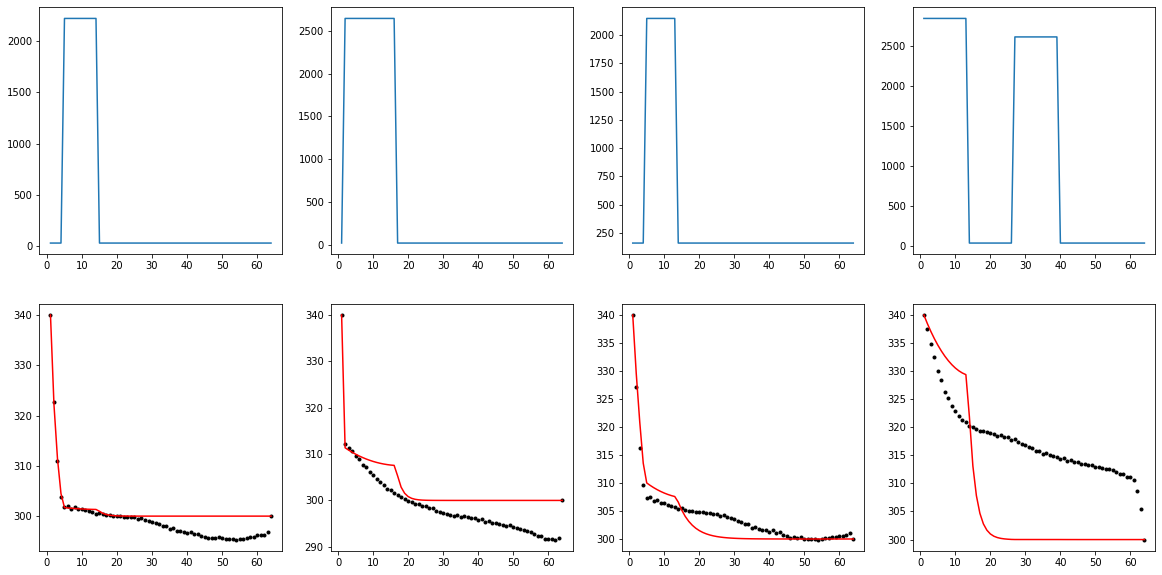

In [41]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C1[55], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[55], 'r')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C1[14], 'k.', lw = 1)
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[14], 'r-')
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C1[64], 'k.', lw = 1)
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[64], 'r-')
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C1[21], 'k.', lw = 1)
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[21], 'r-')  

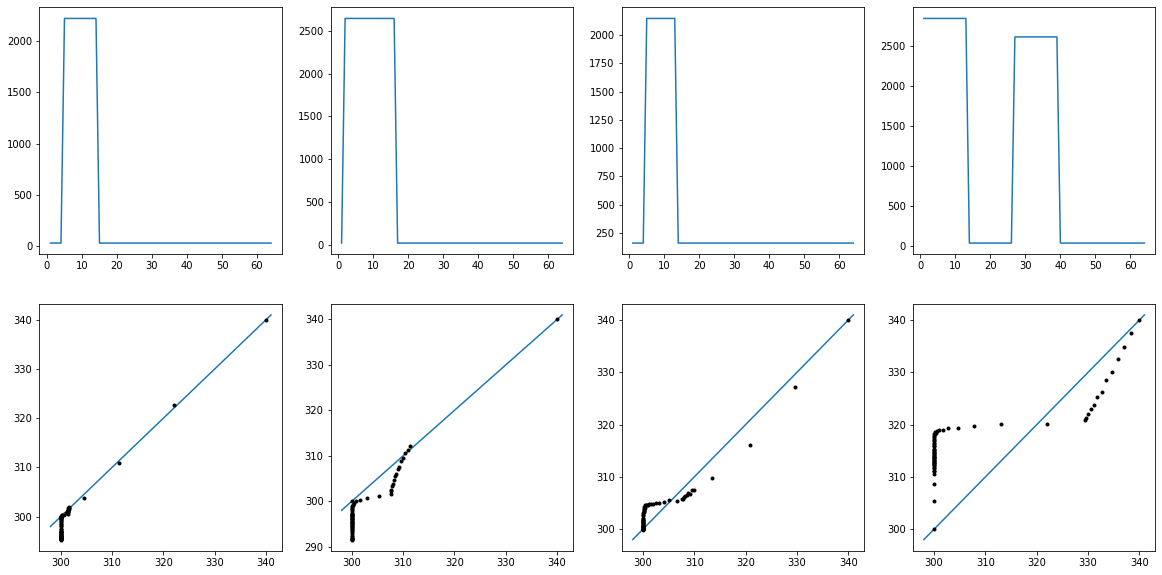

In [42]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(298, 342), range(298, 342))
ax[1, 0].plot(test_press_1day_64pixel[55], test_pred_C1[55], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(298, 342), range(298, 342))
ax[1, 1].plot(test_press_1day_64pixel[14], test_pred_C1[14], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(298, 342), range(298, 342))
ax[1, 2].plot(test_press_1day_64pixel[64], test_pred_C1[64], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(298, 342), range(298, 342))
ax[1, 3].plot(test_press_1day_64pixel[21], test_pred_C1[21], 'k.')

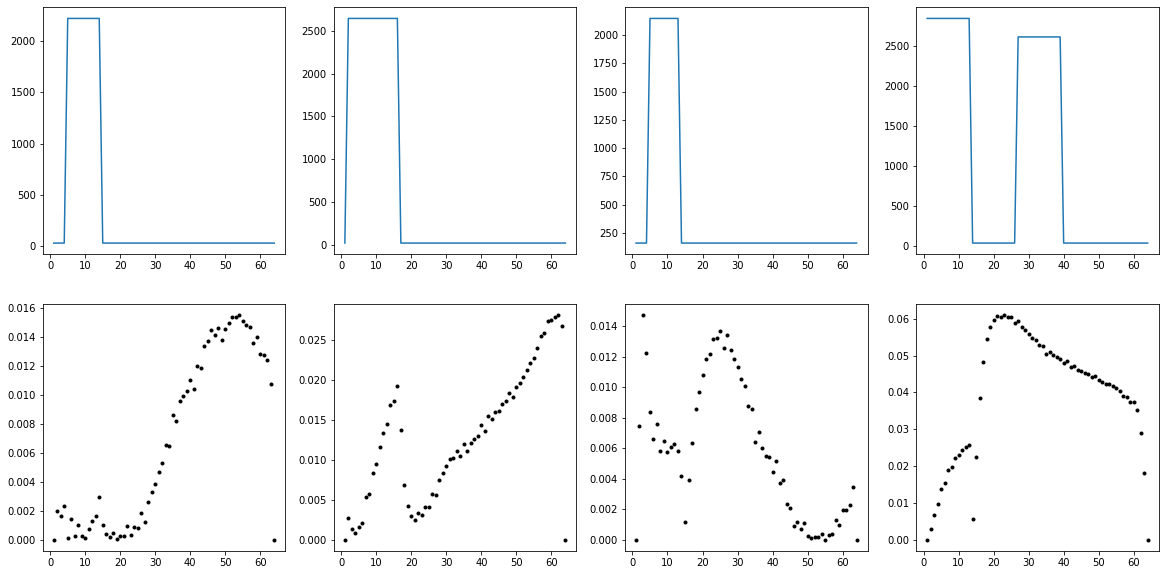

In [43]:
test_pred_C1_rel_error = np.abs(test_pred_C1.reshape(100, 64) - test_press_1day_64pixel) / test_press_1day_64pixel

# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[55])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C1_rel_error[55], 'k.')
ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[14])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C1_rel_error[14], 'k.', lw = 1)
ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[64])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C1_rel_error[64], 'k.', lw = 1)
ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[21])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C1_rel_error[21], 'k.', lw = 1)

(array([1167.,  922.,  814.,  692.,  608.,  504.,  369.,  170.,   79.,
          60.,   26.,   57.,   68.,  113.,  136.,  140.,  145.,   92.,
          64.,   50.,   32.,   26.,   19.,   17.,   12.,    3.,    3.,
           4.,    4.,    4.]),
 array([0.        , 0.00310499, 0.00620997, 0.00931496, 0.01241995,
        0.01552493, 0.01862992, 0.02173491, 0.02483989, 0.02794488,
        0.03104986, 0.03415485, 0.03725984, 0.04036482, 0.04346981,
        0.0465748 , 0.04967978, 0.05278477, 0.05588976, 0.05899474,
        0.06209973, 0.06520472, 0.0683097 , 0.07141469, 0.07451968,
        0.07762466, 0.08072965, 0.08383464, 0.08693962, 0.09004461,
        0.09314959]),
 <a list of 30 Patch objects>)

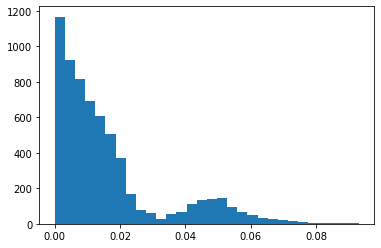

In [44]:
plt.hist(test_pred_C1_rel_error.reshape(-1), bins = 30)

In [45]:
print(np.mean(test_pred_C1_rel_error))

0.01605892536333637


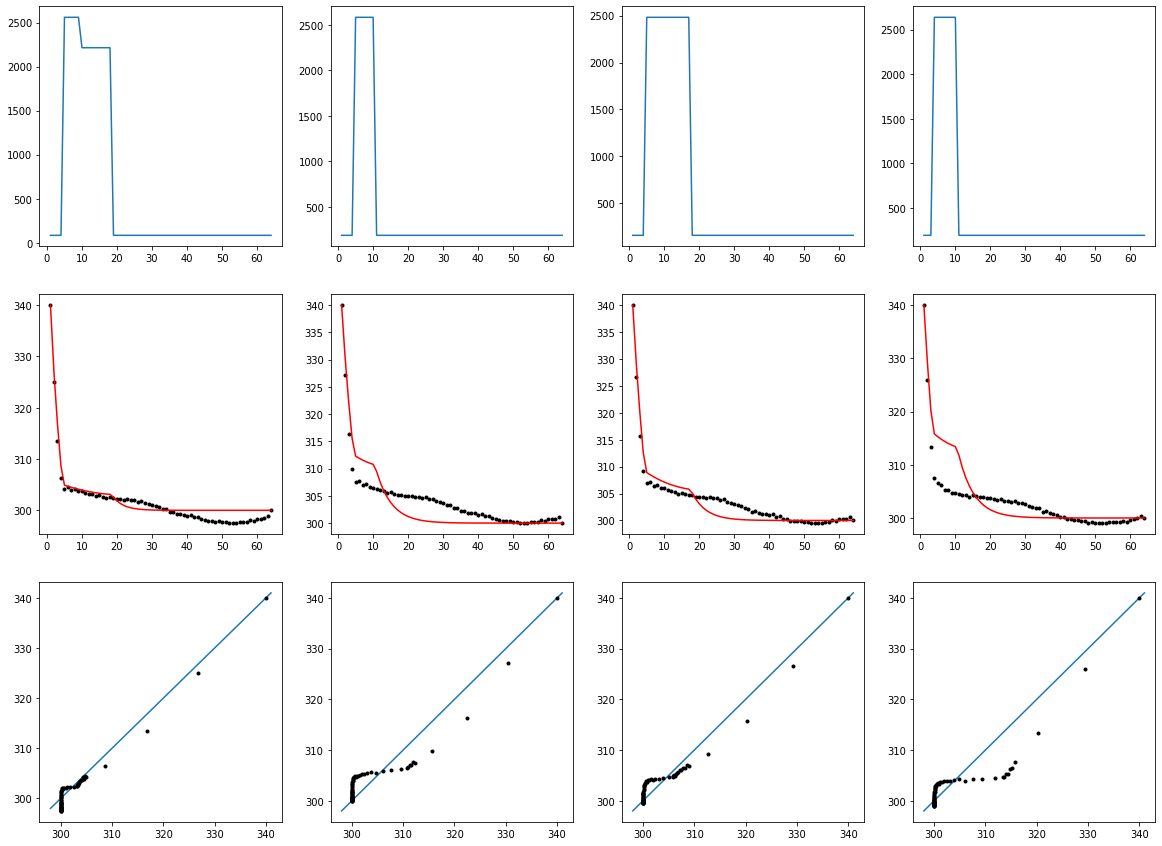

In [46]:
# draw predicted pressure curves for test perm data
pixel = 64
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(20, 15, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[15])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C1[15], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[15], 'r-')
ax[2, 0].plot(range(298, 342), range(298, 342))
ax[2, 0].plot(test_press_1day_64pixel[15], test_pred_C1[15], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[74])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C1[74], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[74], 'r-')
ax[2, 1].plot(range(298, 342), range(298, 342))
ax[2, 1].plot(test_press_1day_64pixel[74], test_pred_C1[74], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[32])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C1[32], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[32], 'r-')
ax[2, 2].plot(range(298, 342), range(298, 342))
ax[2, 2].plot(test_press_1day_64pixel[32], test_pred_C1[32], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[98])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C1[98], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[98], 'r-') 
ax[2, 3].plot(range(298, 342), range(298, 342))
ax[2, 3].plot(test_press_1day_64pixel[98], test_pred_C1[98], 'k.')

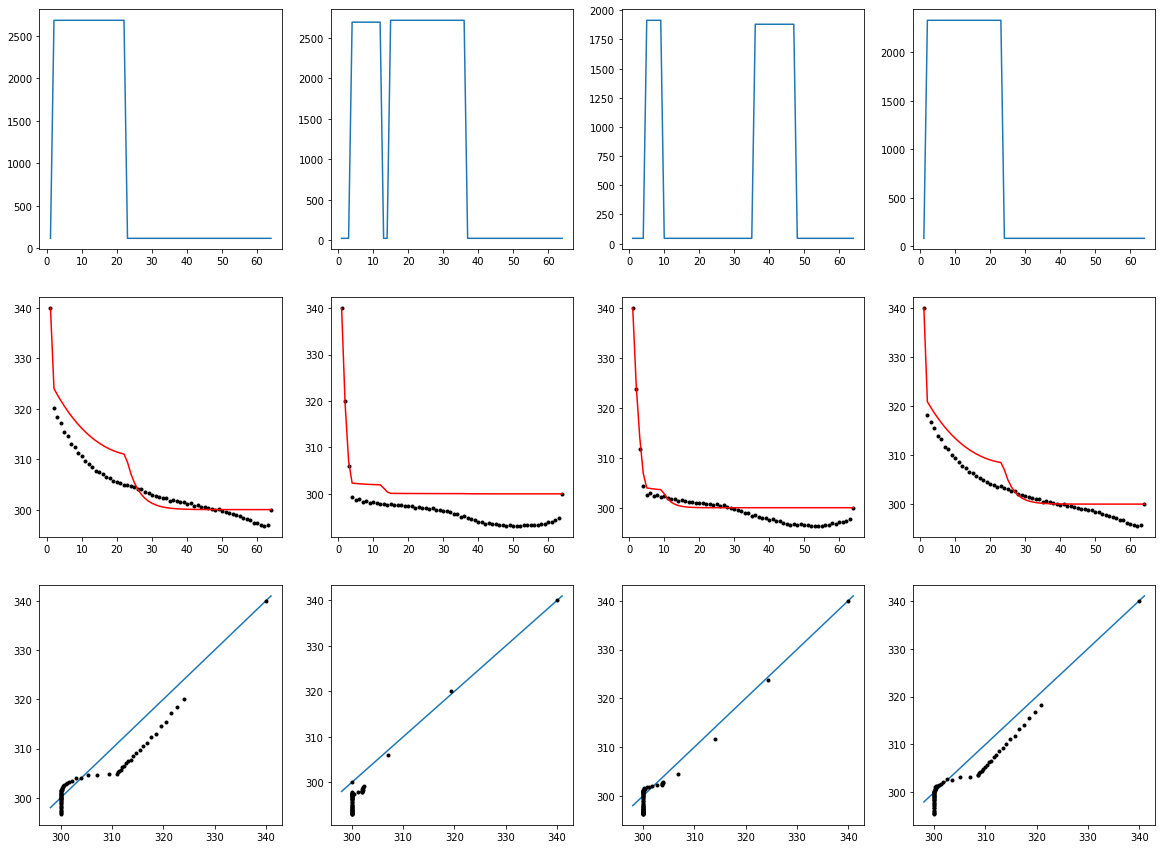

In [47]:
# draw predicted pressure curves for test perm data
test_index = [3, 46, 60, 91]

pixel = 64
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(20, 15, forward=True)
ax[0, 0].plot(range(1, pixel + 1), test_perm_64pixel[test_index[0]])
ax[1, 0].plot(range(1, pixel + 1), test_pred_C1[test_index[0]], 'k.')
ax[1, 0].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[0]], 'r-')
ax[2, 0].plot(range(298, 342), range(298, 342))
ax[2, 0].plot(test_press_1day_64pixel[test_index[0]], test_pred_C1[test_index[0]], 'k.')

ax[0, 1].plot(range(1, pixel + 1), test_perm_64pixel[test_index[1]])
ax[1, 1].plot(range(1, pixel + 1), test_pred_C1[test_index[1]], 'k.')
ax[1, 1].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[1]], 'r-')
ax[2, 1].plot(range(298, 342), range(298, 342))
ax[2, 1].plot(test_press_1day_64pixel[test_index[1]], test_pred_C1[test_index[1]], 'k.')

ax[0, 2].plot(range(1, pixel + 1), test_perm_64pixel[test_index[2]])
ax[1, 2].plot(range(1, pixel + 1), test_pred_C1[test_index[2]], 'k.')
ax[1, 2].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[2]], 'r-')
ax[2, 2].plot(range(298, 342), range(298, 342))
ax[2, 2].plot(test_press_1day_64pixel[test_index[2]], test_pred_C1[test_index[2]], 'k.')

ax[0, 3].plot(range(1, pixel + 1), test_perm_64pixel[test_index[3]])
ax[1, 3].plot(range(1, pixel + 1), test_pred_C1[test_index[3]], 'k.')
ax[1, 3].plot(range(1, pixel + 1), test_press_1day_64pixel[test_index[3]], 'r-') 
ax[2, 3].plot(range(298, 342), range(298, 342))
ax[2, 3].plot(test_press_1day_64pixel[test_index[3]], test_pred_C1[test_index[3]], 'k.')

In [77]:

bound_sta_value = 340
bound_end_value = 300

test_pred_C1_rel_error = np.abs(test_pred_C1.reshape(100, 64) - test_press_1day_64pixel) / ((bound_sta_value-bound_end_value))

In [78]:
test_pred_C1_rel_error.shape

(100, 64)

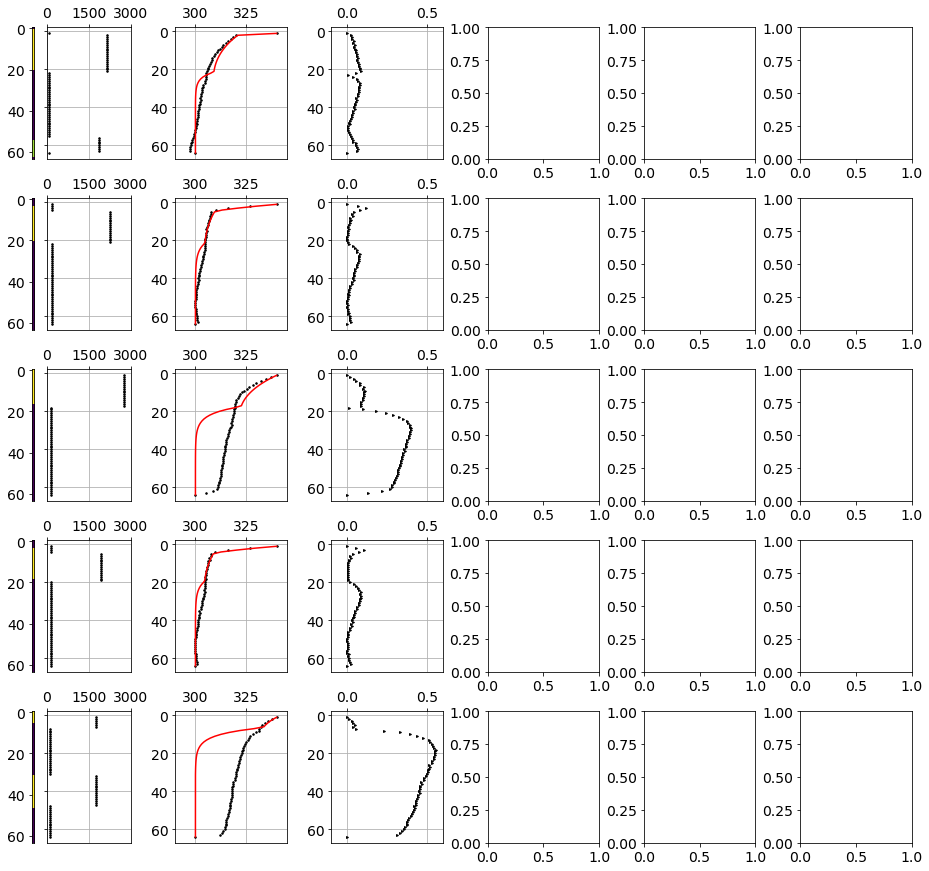

In [85]:
plt.rcParams.update({'font.size': 14})

test_perm_64pixel_2d = np.expand_dims(test_perm_64pixel, axis = -1)
test_press_1day_64pixel_2d = np.expand_dims(test_press_1day_64pixel, axis = -1)

test_ind_list = [11, 12, 23, 35, 59]
ex_no = len(test_ind_list)

fig, ax = plt.subplots(5, 6)
fig.set_size_inches(16, 15, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)


for i in range(ex_no):
    ax[i, 0].set_frame_on(False)
    ax[i, 0].tick_params(bottom=False, left=False)
    ax[i, 0].set(xticks=[], yticks=[])  # remove the tick lab
    ax_left = ax[i, 0].inset_axes([0., 0., 0.25, 1])
    ax_right = ax[i, 0].inset_axes([0.25, 0., 0.75, 1])
    ax_left.imshow(test_perm_64pixel_2d[test_ind_list[i]])
    ax_left.tick_params(bottom=False)  # remove the ticks
    ax_left.set(xticks=[])  # remove the tick lab
    ax_right.plot(test_perm_64pixel_2d[test_ind_list[i]], range(1, 65), 'k.', markersize=3)
    ax_right.invert_yaxis()
    ax_right.tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax_right.xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax_right.tick_params(axis='y', left=True)  # Set ticks on the top of y-axis
    ax_right.yaxis.set_tick_params(labelleft= False)
    ax_right.grid(True)
    ax_right.set_xlim(0, 3000)
    ax_right.xaxis.set_ticks((0, 1500, 3000))
    
    ax[i, 1].plot(test_pred_C1[test_ind_list[i]], range(1, 65), 'k.', markersize=3)
    ax[i, 1].plot(test_press_1day_64pixel[test_ind_list[i]], range(1, 65), 'r-') 
    ax[i, 1].invert_yaxis()
    ax[i, 1].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax[i, 1].xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax[i, 1].grid(True)
    ax[i, 1].set_xlim(290, 345)
    
    ax[i, 2].plot(test_pred_C1_rel_error[test_ind_list[i]], range(1, 65), 'k>', markersize=2)
    ax[i, 2].invert_yaxis()
    ax[i, 2].grid(True)
    ax[i, 2].tick_params(axis='x', top=True, bottom = False)  # Set ticks on the top of X-axis
    ax[i, 2].xaxis.set_tick_params(labeltop=True, labelbottom = False)
    ax[i, 2].set_xlim(-0.1, 0.6)

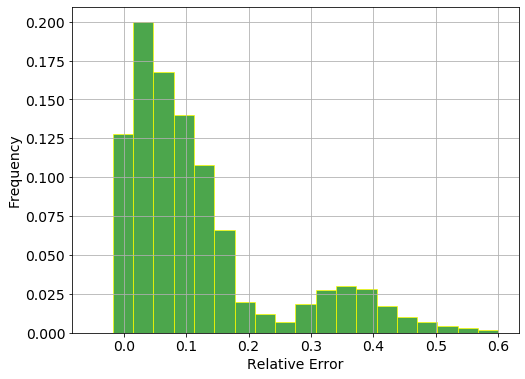

In [83]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 6))

error = test_pred_C1_rel_error.reshape(-1)
plt.hist(error, bins = 20, ec="yellow", fc="g", alpha=0.7, weights=np.zeros_like(error) + 1. / len(error), range = (-0.05, 0.6))
# 
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
# plt.title('Histogram of IQ')
plt.grid(True)

#plt.savefig(Sur_network_dir + "Hist_R2 error.png", dpi=150) 

In [84]:
error_mean = np.mean(error)
error_std = np.std(error)

print(error_mean)
print(error_std)

0.12162935841083528
0.12603630272487065


In [87]:
mg_time_V1_st = time.time()


# predict pressure curves using NN pipelines for test permeability curves
test_perms = [test_perm_64pixel]
test_ini_res = np.zeros(test_perm_64pixel.shape)
test_ini_pred = np.zeros(test_perm_64pixel.shape)
test_pred_C1, test_res_C1 = NNs_pipl_C1.mapping(test_perms, test_ini_res, test_ini_pred)

mg_time_V1_ed = time.time()
print('Seconds used: ' + str(mg_time_V1_ed - mg_time_V1_st))
print("Seconds used for each perm curve:" + str((mg_time_V1_ed - mg_time_V1_st)/100))

Seconds used: 0.07142996788024902
Seconds used for each perm curve:0.0007142996788024902
